# Data Extraction 

In [1]:
#Imports
import pandas as pd
import numpy as np
import datetime
import os
import warnings
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import doctest
from collections import defaultdict

In [2]:
warnings.filterwarnings('ignore')

## Connect to database 

In [3]:
# Load the file 
json_data = json.loads(open('../../db_conn.json').read())

conn = 'mysql+pymysql://'+json_data["user"]+':'+json_data["password"]+'@'+json_data["host"]+':'+str(json_data["port"])+'/'+json_data["db_name"]

In [4]:
# Connect to the DB
mysql_engine = create_engine(conn,echo=False)

## Retrieve the dataset

The dataset used will have the following characteristics, which were derived from EDA step:

* We will include sales for products 45, 5, and 9 only.
* We will ignore stores related to weather stations 5 and 8.
* The model will be fitted to predict daily sales of one of the top 3 products, therefore, we will require daily sales for each of the products in every relevant store using a timestamp.

In [5]:
q = """select t.item_nbr, t.units, t.store_nbr, w.* FROM train as t
left join RetailWeather.key as s on t.store_nbr = s.store_nbr
left join RetailWeather.weather as w on s.station_nbr = w.station_nbr and t.date = w.date
where t.item_nbr in (45, 9, 5) and s.station_nbr not in (5, 8);"""

In [6]:
sales_df = pd.read_sql_query(q, conn)

In [7]:
sales_df.date = pd.to_datetime(sales_df.date)

Now that we have what we wanted, let's start cleaning. 

# Slicing the data 

Select only relevant features according to [EDA](EDA.ipynb) performed, this means:
* Filtering fields of interest for weather variables
* Leaving `store_nbr` and `station_nbr` in order to to match station clusters. 

In [8]:
sales_data = sales_df[['date', 'item_nbr', 
                       'store_nbr', 'station_nbr', 'tmax', 
                       'codesum', 'preciptotal', 'stnpressure','avgspeed','units']]

In [9]:
sales_data.head()

,date,item_nbr,store_nbr,station_nbr,tmax,codesum,preciptotal,stnpressure,avgspeed,units
0,2012-01-01,5,1,1,52.0,RA FZFG BR,0.05,29.78,4.6,0
1,2012-01-01,9,1,1,52.0,RA FZFG BR,0.05,29.78,4.6,29
2,2012-01-01,45,1,1,52.0,RA FZFG BR,0.05,29.78,4.6,0
3,2012-01-02,5,1,1,50.0,,0.01,29.44,10.3,0
4,2012-01-02,9,1,1,50.0,,0.01,29.44,10.3,60


In [10]:
sales_data.shape

(119298, 10)

# Data transformation 

## Breaking down the `codesum` feature 

In this column, we have multiple codes for different kinds of *weather phenomena*, this information might be usefull for identifying specific features of weather that could impact sales such as rain, snow, thunderstorms, etc. We will break down this column to create multiple boolean features containing these kinds of events. Let's explore how it looks:

In [11]:
sales_data.codesum.unique()[0:20]

array(['RA FZFG BR', ' ', 'SN', 'RA SN BR', 'RA FZRA FG+ FG BR UP',
       'SN BR', 'RA SN BR HZ', 'RA', 'RA BR', 'BR', 'RA FZRA SN BR UP',
       'RA FG+ FG FZFG BR HZ', 'SN FG BR', 'SN FG+ FZFG BR',
       'RA SN FG+ BR', 'RA HZ', 'FG BR', 'BR HZ', 'RA BR HZ', 'HZ'],
      dtype=object)

In [12]:
def break_codesum(string):
    """
    Take one string from codesum and break it into a list of elements given the spaces inside the string.
    Example:
    
    >>> break_codesum('RA RA FZFG BR')
    {'RA': 2, 'FZFG': 1, 'BR': 1}
    """
    
    import re
    from collections import defaultdict
    
    if string.strip() != '':
        sym_count = defaultdict(int)
        for sym in re.split('\s+', string.strip()):
            sym_count[sym] += 1
    else:
        sym_count = {}
    
    return dict(sym_count)

if __name__ == '__main__':
    import doctest
    doctest.run_docstring_examples(break_codesum, globals())

Now apply the function `break_codesum` to the whole `codesum` field to see the results: 

In [13]:
codesum_df = pd.DataFrame.from_dict([break_codesum(string) for idx, string in enumerate(sales_data.codesum)])
codesum_df.fillna(0,inplace=True)

In [14]:
codesum_df.head()

,RA,FZFG,BR,SN,FZRA,FG+,FG,UP,HZ,TSRA,...,PL,MIFG,VCFG,BLDU,SQ,GR,TSSN,GS,SG,PRFG
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's check how frequent are these events with respect to the amount of days analyzed: 

Text(0.5, 1.0, 'Frequency of different weather phenomena')

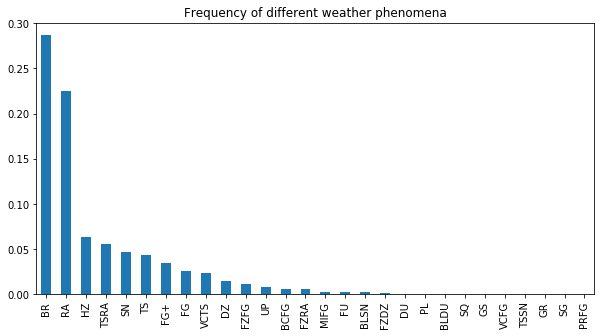

In [15]:
fig,ax = plt.subplots(1,1, figsize=(10,5))
codesum_df.sum().divide(codesum_df.shape[0]).sort_values(ascending=False).plot(kind='bar', ax=ax)
ax.set_title('Frequency of different weather phenomena')

We have that the most common events will be mist (BR), rain (RA), haze (HZ), thunderstorm and rain (TSRA), snow (SN) and thunderstorms alone (TS). All of those with 5% of occurrance in the dataset or more. We can filter out relevant information further to exclude very anomalous events such as snow grains, that are very uncommon. For this we selected the top 11 events, which happen to have more than 1% ocurrance in the dataset.

Having this information, now we can append the `codesum_df` dataset to our `sales_data` in order to have the weather features related to each product sales data.

In [16]:
#Get fields to remove
to_remove = codesum_df.columns[~codesum_df.columns.isin(['BR','RA', 'HZ', 'TSRA', 'SN', 'TS', 
                                                         'FG+', 'VCTS', 'FG', 'DZ', 'FZFG'])].to_list()
to_remove.append('codesum')
#Append to dataframe
sales_data = sales_data.merge(codesum_df, left_index=True, right_index=True)
# Clean the dataset
sales_data = sales_data[sales_data.columns[~sales_data.columns.isin(to_remove)]]

In [17]:
sales_data.shape

(119298, 20)

## Adding new time-related variables

We will also add some interesting time-related variables that could impact sales, such as:

* Weekend vs weekday (boolean)
* Quantity sold the previous day (int)
* Month of the year (cyclical)

### Weekend vs. Weekday  

In [18]:
sales_data['weekend'] = sales_data.date.apply(lambda x: x.weekday() in [6,5])

### Quantity sold the previous day 

We will first define a function to get the values for the day before (if exist): 

In [19]:
def get_previous_quantity(df, q='units', date='date'):
    """Takes a dataframe with a date column and a quantity column and appends a new column with the 
    quantity for the previous day. If there were no quantities the day before, it returns zero.
    
    >>> from datetime import datetime, timedelta 
    >>> import pandas as pd
    
    >>> sales = {'date': [datetime.today() - timedelta(days=4),\
    datetime.today() - timedelta(days=2),\
    datetime.today() - timedelta(days=1),\
    datetime.today()], \
    'units': [5,4,3,2]}
    
    >>> sales_df = pd.DataFrame(sales)
    
    >>> get_previous_quantity(sales_df)['previous_units'].to_list()
    [0.0, 0.0, 4.0, 3.0]
    
    """
    from datetime import timedelta
    
    df = df.sort_values(by=date, ascending=True)
    
    # Calculate previous day's units
    df['previous_units'] = df[q].shift(1)
    df.loc[df['previous_units'].isna(), 'previous_units'] = 0
    
    # Flag if the difference between current and previous is 1 day
    df['has_prev_day'] = df[date].diff() == timedelta(1)
    
    # Set to zero if it's not
    df.loc[df['has_prev_day'] == False, 'previous_units'] = 0
    
    df.drop(columns=['has_prev_day'], inplace=True)
    
    return df

if __name__ == '__main__':
    import doctest
    doctest.run_docstring_examples(get_previous_quantity, globals())
    

Now, we are going to loop over the rows of the dataframe with the three different `item_nbr` in order to get the previous quantity for every product at every store.   

In [20]:
for product in sales_data.item_nbr.unique():
    for store in sales_data.store_nbr.unique():
        if (product == 5) and (store == 1):
            #Create first dataframe
            sales_new = get_previous_quantity(sales_data.loc[(sales_data.item_nbr == product) & (sales_data.store_nbr == store)])
        else:
            #Append to previous dataframe
            current_df = get_previous_quantity(sales_data.loc[(sales_data.item_nbr == product) & (sales_data.store_nbr == store)])
            sales_new = sales_new.append(current_df)
            
sales_new.reset_index(inplace=True, drop=True)

In [21]:
#Check it out to see how it works
sales_new[2000:2005]

,date,item_nbr,store_nbr,station_nbr,tmax,preciptotal,stnpressure,avgspeed,units,RA,...,SN,FG+,FG,HZ,TSRA,TS,VCTS,DZ,weekend,previous_units
2000,2012-08-02,5,21,3,112.0,0.00,28.98,7.8,18,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,77.0
2001,2012-08-03,5,21,3,107.0,0.00,29.02,10.4,67,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,18.0
2002,2012-08-04,5,21,3,109.0,0.23,29.13,10.9,43,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,67.0
2003,2012-08-05,5,21,3,96.0,0.12,29.37,6.5,108,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,43.0
2004,2012-08-06,5,21,3,102.0,0.00,29.27,3.8,63,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,108.0


In [22]:
sales_new.columns

Index(['date', 'item_nbr', 'store_nbr', 'station_nbr', 'tmax', 'preciptotal',
       'stnpressure', 'avgspeed', 'units', 'RA', 'FZFG', 'BR', 'SN', 'FG+',
       'FG', 'HZ', 'TSRA', 'TS', 'VCTS', 'DZ', 'weekend', 'previous_units'],
      dtype='object')

## Engineering for time variables

Having our `date` variable, and in order to add derived variables such as *month of the year*, we need to make sure that these act as cyclical variable in our model, which is their nature. We will apply a transformation to preserve the cyclical characteristics of months, i.e. the last month of the year is close to the first one of the following year. [LINK](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html)

This transformation is explained in the following picture:

![alt text](http://blog.davidkaleko.com/images/unit_circle.png)


### Create derived variables of interest 

In [23]:
sales_new['month'] = sales_new.date.dt.month 

### Transform variables into cyclical variables using sine and cosine

In [24]:
sales_new['month_sin'] = np.sin(sales_new.month*(2.*np.pi/12))
sales_new['month_cos'] = np.cos(sales_new.month*(2.*np.pi/12))

In [25]:
sales_new.head()

,date,item_nbr,store_nbr,station_nbr,tmax,preciptotal,stnpressure,avgspeed,units,RA,...,HZ,TSRA,TS,VCTS,DZ,weekend,previous_units,month,month_sin,month_cos
0,2012-01-01,5,1,1,52.0,0.05,29.78,4.6,0,1.0,...,0.0,0.0,0.0,0.0,0.0,True,0.0,1,0.5,0.866025
1,2012-01-02,5,1,1,50.0,0.01,29.44,10.3,0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,0.0,1,0.5,0.866025
2,2012-01-03,5,1,1,32.0,0.00,29.67,11.6,0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,0.0,1,0.5,0.866025
3,2012-01-04,5,1,1,28.0,0.00,29.86,8.3,0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,0.0,1,0.5,0.866025
4,2012-01-05,5,1,1,38.0,0.00,29.67,7.8,0,0.0,...,0.0,0.0,0.0,0.0,0.0,False,0.0,1,0.5,0.866025


## Assign cluster number 

Now, with the map extracted from [EDA](EDA.ipynb), we will assign the cluster number to each of the stations (and stores).

In [26]:
labels_map = pd.read_csv('labels_map.csv', index_col='stores')

In [27]:
sales_new['city'] = sales_new.station_nbr.apply(lambda x: labels_map.at[x,'cluster'])

In [28]:
sales_new.head()

,date,item_nbr,store_nbr,station_nbr,tmax,preciptotal,stnpressure,avgspeed,units,RA,...,TSRA,TS,VCTS,DZ,weekend,previous_units,month,month_sin,month_cos,city
0,2012-01-01,5,1,1,52.0,0.05,29.78,4.6,0,1.0,...,0.0,0.0,0.0,0.0,True,0.0,1,0.5,0.866025,1
1,2012-01-02,5,1,1,50.0,0.01,29.44,10.3,0,0.0,...,0.0,0.0,0.0,0.0,False,0.0,1,0.5,0.866025,1
2,2012-01-03,5,1,1,32.0,0.00,29.67,11.6,0,0.0,...,0.0,0.0,0.0,0.0,False,0.0,1,0.5,0.866025,1
3,2012-01-04,5,1,1,28.0,0.00,29.86,8.3,0,0.0,...,0.0,0.0,0.0,0.0,False,0.0,1,0.5,0.866025,1
4,2012-01-05,5,1,1,38.0,0.00,29.67,7.8,0,0.0,...,0.0,0.0,0.0,0.0,False,0.0,1,0.5,0.866025,1


We have all the desired variables to fit the model, and at the end, we would have to obtain 3 models for each product, for a total of 6 models. However, first, we have to make some more preprocessing on the data.

## Removing NAs 

In [29]:
sales_new.isna().sum()

date                0
item_nbr            0
store_nbr           0
station_nbr         0
tmax              507
preciptotal       195
stnpressure       390
avgspeed          264
units               0
RA                  0
FZFG                0
BR                  0
SN                  0
FG+                 0
FG                  0
HZ                  0
TSRA                0
TS                  0
VCTS                0
DZ                  0
weekend             0
previous_units      0
month               0
month_sin           0
month_cos           0
city                0
dtype: int64

We will have to impute on those values in order to feed the model with complete data. For this, we are going to calculate the average among the previous 5 values and the following 5 values to the null field and set it to this value. We do this as follows:

In [30]:
#Get columns with null values
for col in sales_new.isna().sum().index[sales_new.isna().sum()>0]:
    # Iterate over null indices of column
    for idx in sales_new[sales_new[col].isna()].index:
        #Set value of current index
        sales_new.loc[idx,col] = np.nanmean(sales_new.loc[idx-5:idx+5,col].to_list())

In [31]:
sales_new.isna().sum()

date              0
item_nbr          0
store_nbr         0
station_nbr       0
tmax              0
preciptotal       0
stnpressure       0
avgspeed          0
units             0
RA                0
FZFG              0
BR                0
SN                0
FG+               0
FG                0
HZ                0
TSRA              0
TS                0
VCTS              0
DZ                0
weekend           0
previous_units    0
month             0
month_sin         0
month_cos         0
city              0
dtype: int64

## Outliers 
Now we'll evaluate ouliers in the numerical data:

In [32]:
continuous = ['tmax', 'preciptotal', 'stnpressure', 'avgspeed', 'units']

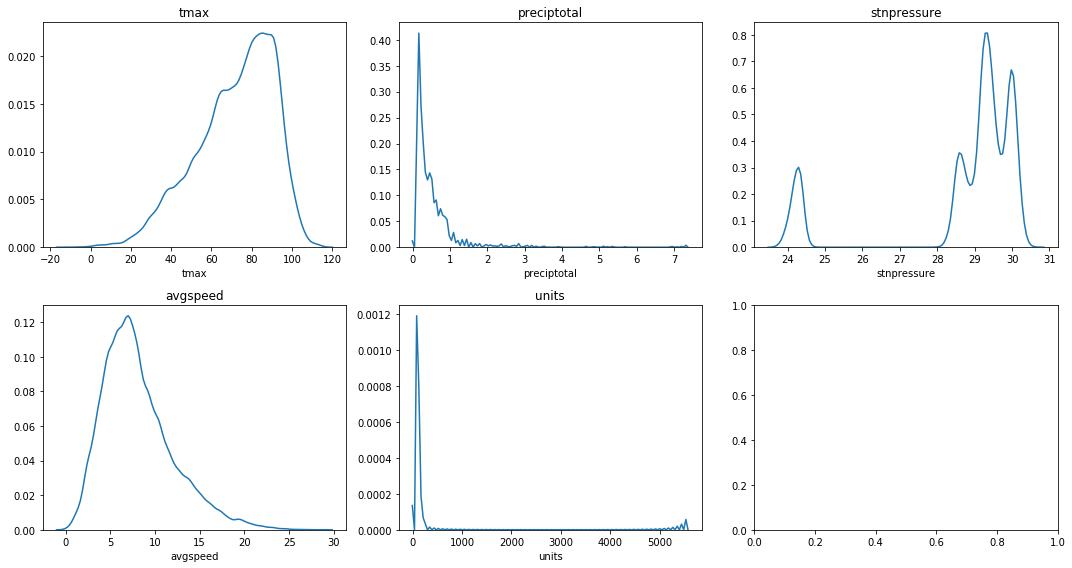

In [33]:
fig, axes = plt.subplots(2,3, figsize=(15,8))
for ax, var in zip(axes.flat, continuous):
    sns.distplot(sales_new[var], hist=False, ax=ax)
    ax.set_title(var)
    fig.tight_layout()

There doesn't seem to be significant outliers, except for the `units` and `preciptotal` which we will have to deal with. For this, we are going to analyze them one by one.

#### `units` outliers detection 

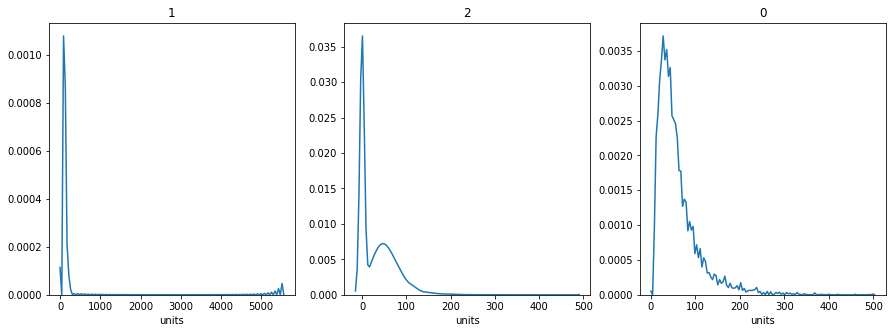

In [34]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharex=False)
for ax, city in zip(axes.flat, sales_new.city.unique()):
    sns.distplot(sales_new.loc[sales_new.city == city, 'units'], ax=ax, hist=False)
    ax.set_title(city)

Outliers exist in city 1, in which we have days with more than 5.000 units sold, let's check if this happens in one particular store. 

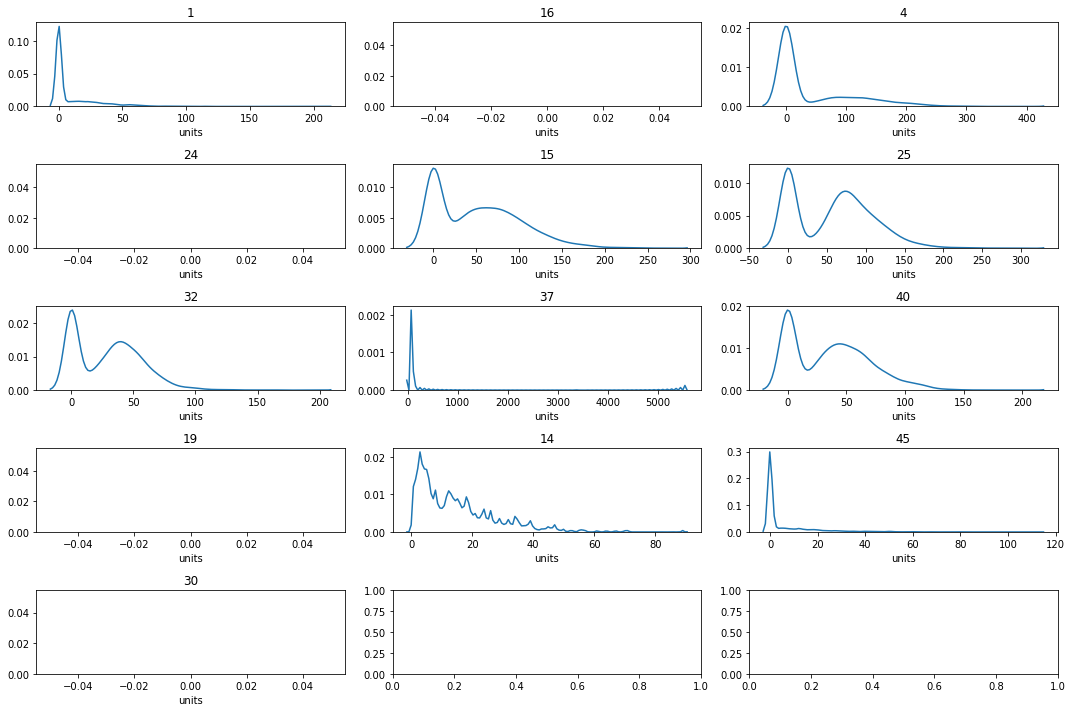

In [35]:
fig, axes = plt.subplots(5,3, figsize=(15,10), sharex=False)
for ax, store in zip(axes.flat, sales_new.loc[sales_new.city == 1, 'store_nbr'].unique()):
    sns.distplot(sales_new.loc[sales_new.store_nbr == store, 'units'], ax=ax, hist=False)
    ax.set_title(store)

fig.tight_layout()

This is happening in store 37, having some very extreme values over 5000. We will draw a line at 200 products for this analysis, anything over that will be considered outlier

In [36]:
sales_new = sales_new[sales_new.units<=200]

#### `preciptotal` outliers detection 

Let's review it at the city level 

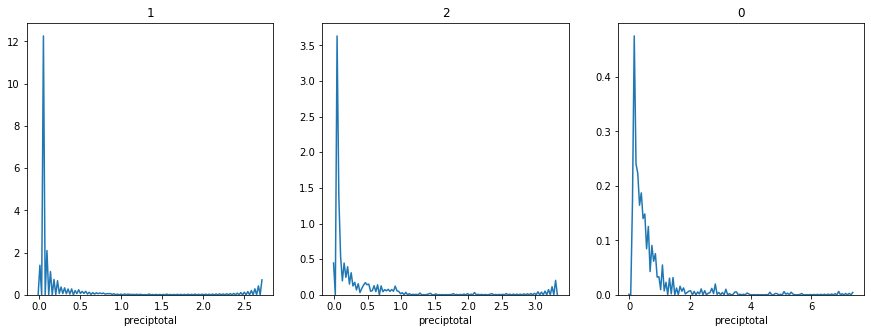

In [37]:
fig, axes = plt.subplots(1,3, figsize=(15,5), sharex=False)
for ax, city in zip(axes.flat, sales_new.city.unique()):
    sns.distplot(sales_new.loc[sales_new.city == city, 'preciptotal'], ax=ax, hist=False)
    ax.set_title(city)

The outliers are present in city 0, let's review it by station.

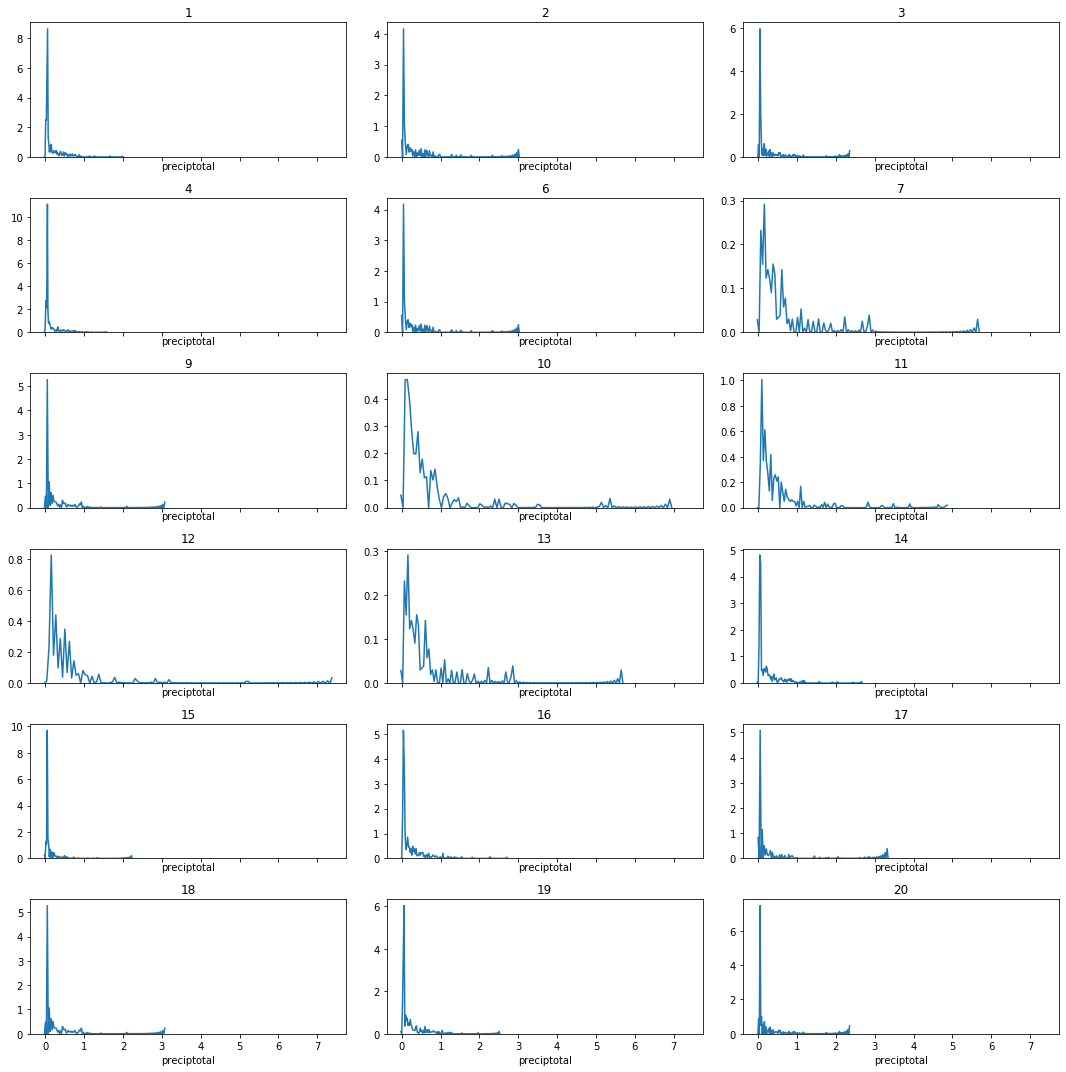

In [38]:
fig, axes = plt.subplots(6,3, figsize=(15,15), sharex=True)
for ax, store in zip(axes.flat, sales_new.loc[:, 'station_nbr'].unique()):
    sns.distplot(sales_new.loc[sales_new.store_nbr == store, 'preciptotal'], ax=ax, hist=False)
    ax.set_title(store)

fig.tight_layout()

In [39]:
sales_clean = sales_new[sales_new.preciptotal<=4]

This is how the dataset ends up looking like:

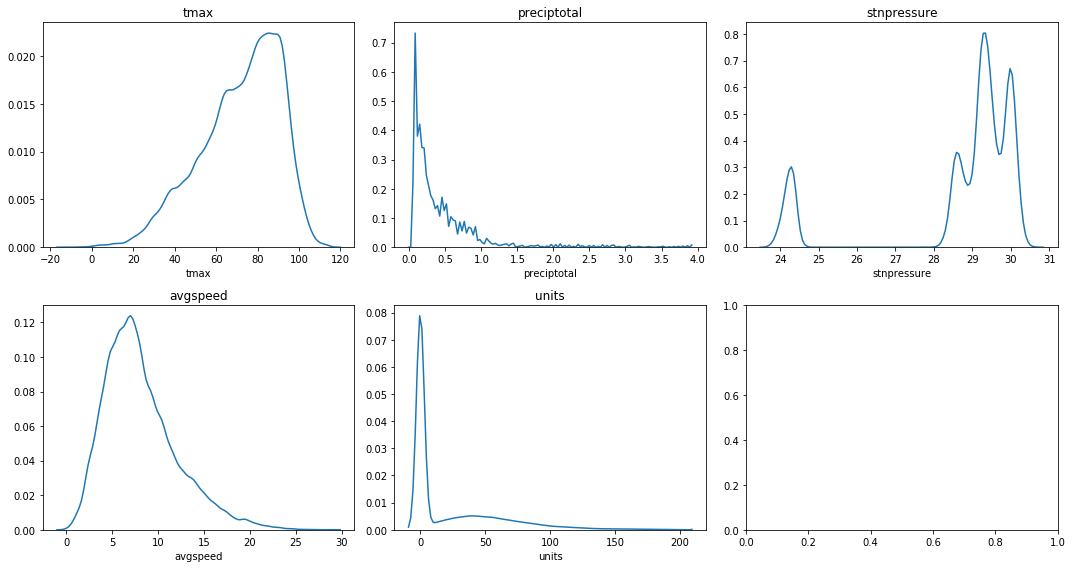

In [40]:
fig, axes = plt.subplots(2,3, figsize=(15,8))
for ax, var in zip(axes.flat, continuous):
    sns.distplot(sales_clean[var], hist=False, ax=ax)
    ax.set_title(var)
    fig.tight_layout()

### Encoding weekend variable 

In [41]:
bool_map = {False: 0, True:1}

In [42]:
sales_clean.weekend = sales_clean.weekend.apply(lambda x: bool_map[x])

# Exporting the dataset 

In [43]:
sales_clean.to_csv('sales_data.csv', index=False)